In [1]:
from data.data_handler import CondDataset
from models.cond import Cond
from models.conv import Conv
from models.condconv import CondConv
from cond_trainer import CondTrainer
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
use_cuda = False#torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cpu')

In [3]:
data_dir = "data/"
stocks = pd.read_csv(data_dir + "ex_aktier.csv")


In [4]:
df = stocks.copy().set_index("Date")
df.index = pd.to_datetime(df.index)
df = df.loc["1999-12-31":"2020-03-31"]
df = df.set_index([df.index, "Isin"]).unstack()["Close"].pct_change()[1:]
df[df == 0.0] = np.nan
mu = df.mean()
std = df.std()

In [5]:
rates = pd.read_csv(data_dir + "rates_philip.csv", sep=";", decimal=",", index_col = 0, parse_dates=True)
cmdty = pd.read_csv(data_dir + "cmdty_philip.csv", sep=";", decimal=",", index_col = 0, parse_dates=True)
index = pd.read_csv(data_dir + "index.csv", index_col =0, parse_dates = True)
Y = rates.join(cmdty).join(index).pct_change()[1:]
Y = Y.reindex(df.index).fillna(0.0).clip(-2,2)[["US10", "SWE10", "NOR10", "Oil", "HEX", "OMX", "OBX", "OMXC"]]
print(Y.columns)
Y.shape, df.shape

Index(['US10', 'SWE10', 'NOR10', 'Oil', 'HEX', 'OMX', 'OBX', 'OMXC'], dtype='object')


((5208, 8), (5208, 2975))

In [6]:
if False:
    NX = 3000
    TT = 5000
    NY = 17
    SX = np.zeros((TT, NX))
    SY = np.zeros((TT, NY))
    dt = 1/252.
    for t in range(TT):
        w = np.random.randn(NX)
        v = np.random.randn(NY)
        SX[t] = 0.01 * dt + 0.2*np.sqrt(dt)*w
        SY[t] = 0.3 * np.sqrt(dt)*v
    df = pd.DataFrame(SX)
    Y = pd.DataFrame(SY)

In [7]:
T = 61
n_x = 5

scaler = StandardScaler()

X = []
y = []
steps = len(df) // T
windows = 400

for t in range(steps-1):
    df_t = df.iloc[t*T:(t+1)*T].dropna(axis=1)
    y_t = Y.iloc[t*T:(t+1)*T]
    #df_t = df_t.sub(df_t.mean(), axis=1).div(df_t.std(), axis=1).dropna(axis=1)
    
    if df_t.shape[1] < n_x:
        continue
    for _ in range(windows):
        i = np.random.choice(np.arange(df_t.shape[1]), n_x, replace=False)
        df_t_i = df_t.iloc[:,i]
        #df_t_i = df_t_i.sub(df_t_i.mean(), axis=1).div(df_t_i.std(), axis=1)
        X.append(df_t_i.values.reshape(-1,1).squeeze())
        y.append(y_t.values.reshape(-1,1).squeeze())
    
    

X = np.array(X)
y = np.array(y)
y.shape, X.shape

((16000, 488), (16000, 305))

In [8]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

# X_mu = X_train.mean(axis=0)
# X_std = X_train.std(axis=0)

# y_mu = y_train.mean(axis=0)
# y_std = y_train.std(axis=0)

# X_train = (X_train - X_mu) / X_std
# X_test = (X_test - X_mu) / X_std
# y_train = (y_train - y_mu) / y_std
# y_test = (y_test - y_mu) / y_std

X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)
y_scaler = StandardScaler()
y_train  = y_scaler.fit_transform(y_train)
y_test = y_scaler.transform(y_test)

In [9]:
X_test.std(axis=0).max()

1.2917009209138965

In [10]:
train_data = CondDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_data = CondDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
Y.shape[1]

8

In [11]:
n_y = Y.shape[1]
n_z = 64
#vae = CondConv(T, n_x, n_y, n_z)
vae = Cond(T, n_x, n_y, n_z)
t = CondTrainer(vae, train_data, test_data, use_cuda, False, T, n_x, n_y)

In [12]:
losses = t.fit(200, burn_in = 0)

Epoch: 0, Train Loss: 258.79, Test Loss:  240.71
Epoch: 10, Train Loss: 179.02, Test Loss:  174.20
Epoch: 20, Train Loss: 165.50, Test Loss:  159.71
Epoch: 30, Train Loss: 159.36, Test Loss:  153.73
Epoch: 40, Train Loss: 155.59, Test Loss:  149.40
Epoch: 50, Train Loss: 152.61, Test Loss:  147.02
Epoch: 60, Train Loss: 150.68, Test Loss:  144.57
Epoch: 70, Train Loss: 149.11, Test Loss:  142.96
Epoch: 80, Train Loss: 147.86, Test Loss:  141.32
Epoch: 90, Train Loss: 146.07, Test Loss:  140.36
Epoch: 100, Train Loss: 145.38, Test Loss:  139.58
Epoch: 110, Train Loss: 144.52, Test Loss:  138.64
Epoch: 120, Train Loss: 143.35, Test Loss:  138.20
Epoch: 130, Train Loss: 143.29, Test Loss:  137.47
Epoch: 140, Train Loss: 142.46, Test Loss:  136.12
Epoch: 150, Train Loss: 141.43, Test Loss:  136.30
Epoch: 160, Train Loss: 140.61, Test Loss:  135.99
Epoch: 170, Train Loss: 140.44, Test Loss:  135.83
Epoch: 180, Train Loss: 140.04, Test Loss:  134.46
Epoch: 190, Train Loss: 139.52, Test Loss:

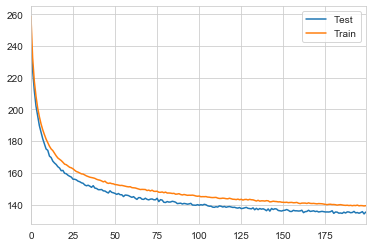

In [13]:
losses.plot()


In [14]:
vae.eval()

Cond(
  (enc): Sequential(
    (0): Linear(in_features=793, out_features=250, bias=True)
    (1): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=250, out_features=125, bias=True)
    (4): BatchNorm1d(125, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=125, out_features=75, bias=True)
    (7): BatchNorm1d(75, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Latent(
      (mu): Linear(in_features=75, out_features=64, bias=True)
      (log_var): Linear(in_features=75, out_features=64, bias=True)
    )
  )
  (dec): Sequential(
    (0): Linear(in_features=552, out_features=75, bias=True)
    (1): BatchNorm1d(75, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=75, ou

In [ ]:
x1, y1 = test_data[45]
x1 = x1.unsqueeze(0).to(device)
y1 = y1.unsqueeze(0).to(device)
#x1 = torch.Tensor(x1.values).unsqueeze(0)
z, mu, log_var = vae.encode(x1, y1)
gen_x = vae.decode(z, y1).view(-1, T,n_x)
gen_x = pd.DataFrame(gen_x[0].cpu().detach().numpy())
gen_x.plot(legend=False)


In [ ]:
xx = pd.DataFrame(x1[0].cpu().detach().numpy().reshape(T,n_x))
xx.plot(legend=False)

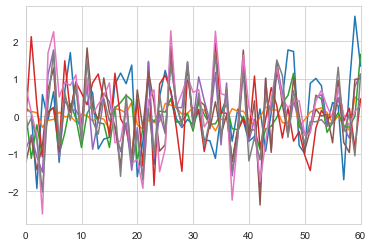

In [17]:
yy = pd.DataFrame(y1[0].cpu().detach().numpy().reshape(T,n_y))
yy.plot(legend=False)

14400
torch.Size([1400, 305])
torch.Size([1400, 64])


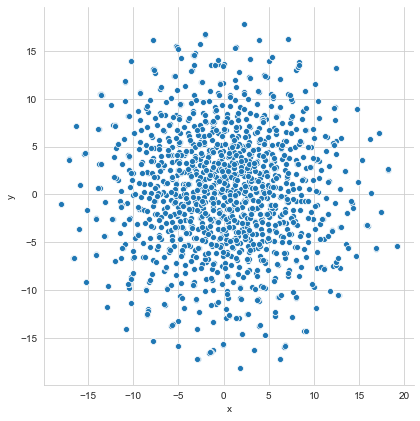

In [18]:
print(len(train_data))
idx = np.random.choice(np.arange(len(train_data)), 1400, replace=False)
X,y = train_data[idx]
print(X.shape)
#X = X.view(X.size(0), X.size(2) * X.size(1))
X = X
Z1, mu, log_var = vae.encode(X.to(device), y.to(device))
print(Z1.shape)
l = Z1.cpu().detach().numpy()
l = TSNE(perplexity=40).fit_transform(l)
d = pd.DataFrame({"x": l[:,0], "y":l[:,1]})
g = sns.pairplot(x_vars="x", y_vars = "y", height=6, data=d)

# g = sns.pairplot(x_vars="x", y_vars = "y", hue="c",height=6, data=df[df.c == 0])
# g = sns.pairplot(x_vars="x", y_vars = "y", hue="c",height=6, data=df[df.c == 1])
# g = sns.pairplot(x_vars="x", y_vars = "y", hue="c",height=6, data=df[df.c == 2])
# Z1.shape

In [19]:
Z1.mean(dim=0), Z1.std(dim=0)**2

(tensor([ 0.0166, -0.0754,  0.0062, -0.0672,  0.0448,  0.0026, -0.0118, -0.1088,
         -0.0350, -0.0819, -0.0777, -0.0179, -0.0379, -0.0583,  0.0390, -0.0365,
          0.0360,  0.0413,  0.0904, -0.0167,  0.0346,  0.0076, -0.0040,  0.0108,
          0.0524, -0.0390, -0.0288, -0.0121, -0.0417, -0.0386,  0.0199,  0.0701,
          0.0707,  0.0091,  0.0461,  0.1151, -0.0471, -0.0421,  0.0401,  0.0291,
          0.1160, -0.0173, -0.0236, -0.0057,  0.0058, -0.0033,  0.0341, -0.0353,
         -0.0374, -0.0480,  0.0476, -0.0583,  0.0012,  0.0474,  0.0233, -0.0200,
         -0.0520,  0.0121, -0.0017,  0.0292, -0.0756, -0.0139, -0.0349,  0.0851],
        grad_fn=<MeanBackward1>),
 tensor([1.3309, 1.2782, 1.0546, 0.9088, 0.9534, 0.9197, 0.9256, 1.4216, 1.2002,
         0.9764, 1.0741, 1.0321, 1.2941, 0.9257, 1.3788, 1.0912, 1.2964, 0.9675,
         1.1467, 1.3450, 1.0876, 1.2513, 1.1266, 0.9240, 1.0293, 1.3277, 0.9517,
         0.9197, 0.9663, 0.9654, 1.0382, 0.9613, 1.2121, 0.9736, 0.9207, 1

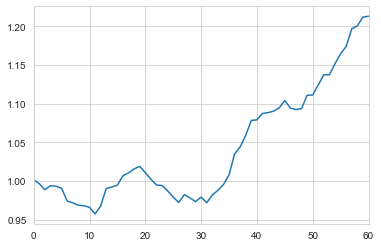

In [29]:
zz = torch.randn([1, n_z])
gen_x = vae.decode(zz, y.unsqueeze(0))#.view(-1, n, T)
gen_x = pd.DataFrame(X_scaler.inverse_transform(gen_x[0].detach().numpy()).reshape(n_x,T).T)
(1.0 + gen_x.mean(axis=1)).cumprod().plot()

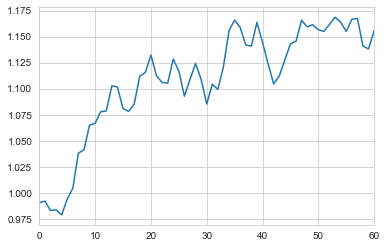

In [28]:
i = np.random.randint(0, len(test_data))
x,y = test_data[i]
yy = pd.DataFrame(y_scaler.inverse_transform(y.detach().numpy()).reshape(T,n_y))
yy.columns = Y.columns
(1.0 + yy["OMX"]).cumprod().plot()